Setup environment and load the base PyPSA-Earth network for a specified country.


In [95]:
# --- Core imports
import os
import sys
import copy
import logging
import warnings
from os.path import join
from pathlib import Path

# --- Numerical / data
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

# --- Power systems / geospatial
import pypsa
import atlite
from shapely.geometry import Point, box
from shapely.ops import unary_union
import shapely

# Optional plotting (only used in helper plot function)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Optional: powerplantmatching (picks up config but we keep local CSV as source of truth)
try:
    import powerplantmatching as pm
    HAVE_PPM = True
except Exception:
    HAVE_PPM = False

# --- Silence noisy warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.filterwarnings('ignore')


# --- Logging
parent_dir = Path(os.getcwd()).parents[0]          # project/
LOG_FILE = join(parent_dir, "logs.log")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    handlers=[logging.FileHandler(LOG_FILE, encoding="utf-8"), logging.StreamHandler(sys.stdout)],
)
logger = logging.getLogger(__name__)

# --- Project paths helper
sys.path.append(str(parent_dir))
from src.paths import all_dirs  # must exist in your repo
dirs = all_dirs()

# --- Add PyPSA-Earth scripts to PATH (assumes repo layout: <project>/../pypsa-earth/scripts)
scripts_path = os.path.join(parent_dir.parents[0], "pypsa-earth", "scripts")
assert os.path.isdir(scripts_path), f"Path not found: {scripts_path}"
sys.path.append(scripts_path)


In [96]:
# 1) Load Networks
network_dir = dirs["data/processed/networks"]
network_files = [
    "network_original",
    "network_snapped",
    "network_expanded",
    "network_expanded_no_orphans",
    "network_nuclear",
    "network_prod_mix",
    "network_base",
]

logger.info("Loading .nc networks …")
networks_dict = {}
for nf in network_files:
    f = join(network_dir, f"{nf}.nc")
    if os.path.isfile(f):
        try:
            networks_dict[nf] = pypsa.Network(f)
            logger.info(f"  ✓ loaded {nf}.nc")
        except Exception as e:
            logger.warning(f"  ⚠ failed to load {nf}.nc: {e}")
    else:
        logger.warning(f"  ⚠ missing file: {f}")

# Work on a copy of the base network
assert "network_base" in networks_dict, "network_base.nc not found/loaded."
network = networks_dict["network_base"].copy()


2025-11-10 12:58:42: Loading .nc networks …
2025-11-10 12:58:42: Imported network network_original.nc has buses, lines, transformers
2025-11-10 12:58:42:   ✓ loaded network_original.nc
2025-11-10 12:58:43: Imported network network_snapped.nc has buses, lines, transformers
2025-11-10 12:58:43:   ✓ loaded network_snapped.nc
2025-11-10 12:58:43: Imported network network_expanded.nc has buses, lines, transformers
2025-11-10 12:58:43:   ✓ loaded network_expanded.nc
2025-11-10 12:58:43: Imported network network_expanded_no_orphans.nc has buses, lines, transformers
2025-11-10 12:58:43:   ✓ loaded network_expanded_no_orphans.nc
2025-11-10 12:58:43: Imported network network_nuclear.nc has buses, lines, transformers
2025-11-10 12:58:43:   ✓ loaded network_nuclear.nc
2025-11-10 12:58:43: Imported network network_prod_mix.nc has buses, lines, transformers
2025-11-10 12:58:43:   ✓ loaded network_prod_mix.nc
2025-11-10 12:58:43: Imported network network_base.nc has buses, lines, transformers
2025-11

In [97]:
# 2) Loads: add p_set time series
# 2) Loads: add p_set time series with nearest-bus remapping for unknown buses
try:
    path_loads = dirs["data/processed/scaled_loads"]
    load_profile_name = "load_base_2030_linear.csv"
    load_profile_file = join(path_loads, load_profile_name)
    logger.info(f"Loading load profile: {load_profile_file}")
    load_profile = pd.read_csv(load_profile_file, index_col=0, parse_dates=True)

    # --- Ensure column names are strings
    load_cols = [str(c) for c in load_profile.columns]
    load_profile.columns = load_cols

    # --- Existing buses in the active network
    buses_now = network.buses.copy()
    buses_now.index = buses_now.index.astype(str)
    existing_buses = set(buses_now.index)

    # --- Find missing bus labels
    missing = [c for c in load_cols if c not in existing_buses]
    if missing:
        logger.warning(f"{len(missing)} load buses not found; reassigning to nearest existing bus.")
    else:
        logger.info("All load buses found in current network.")

    # --- Build KDTree on current network buses
    from scipy.spatial import cKDTree as KDTree
    use_lonlat = {"lon", "lat"}.issubset(buses_now.columns)
    if use_lonlat:
        coords_now = buses_now.loc[:, ["lon", "lat"]].to_numpy(dtype=float)
    else:
        coords_now = buses_now.loc[:, ["x", "y"]].to_numpy(dtype=float)
    kdt_now = KDTree(coords_now)

    # --- Helper: try to get coordinates for a missing bus from any fallback network
    def find_bus_coords_in_fallbacks(bus_name: str):
        for nf, net_fb in networks_dict.items():
            try:
                df = net_fb.buses.copy()
                df.index = df.index.astype(str)
                if bus_name in df.index:
                    if {"lon", "lat"}.issubset(df.columns):
                        return ("lonlat",
                                float(df.loc[bus_name, "lon"]),
                                float(df.loc[bus_name, "lat"]))
                    elif {"x", "y"}.issubset(df.columns):
                        return ("xy",
                                float(df.loc[bus_name, "x"]),
                                float(df.loc[bus_name, "y"]))
            except Exception:
                pass
        return None

    # --- Build a bus assignment vector aligned with load columns
    bus_assignments = []
    remap_report = []

    for c in load_cols:
        if c in existing_buses:
            bus_assignments.append(c)  # unchanged
            continue

        # Try to recover coordinates for this bus label from other networks
        info = find_bus_coords_in_fallbacks(c)
        if info is not None:
            kind, bx, by = info
            # Query KDTree (always built for current network in the coordinate type we have)
            if use_lonlat and kind == "lonlat":
                q = np.array([[bx, by]])
            elif (not use_lonlat) and kind == "xy":
                q = np.array([[bx, by]])
            else:
                # Coordinate kind mismatch; cannot reliably transform → use crude nearest by lon/lat if both exist,
                # else by x/y. If mismatch, try whichever exists in current network.
                if use_lonlat and kind == "xy":
                    # We only have xy for missing, but KDTree is lon/lat → fallback to closest by index 0
                    # (transparent about this in logs)
                    remap_report.append((c, None, None, "coord_kind_mismatch"))
                    # Pick the closest *by index* fallback: use network's geometric center
                    # (KDTree needs a point; we’ll use median lon/lat)
                    q = np.nanmedian(coords_now, axis=0)[None, :]
                elif (not use_lonlat) and kind == "lonlat":
                    remap_report.append((c, None, None, "coord_kind_mismatch"))
                    q = np.nanmedian(coords_now, axis=0)[None, :]
                else:
                    q = np.nanmedian(coords_now, axis=0)[None, :]
            idx = int(kdt_now.query(q)[1][0])
            nearest_bus = buses_now.index[idx]
            bus_assignments.append(nearest_bus)
            remap_report.append((c, bx, by, f"mapped_to:{nearest_bus}"))
        else:
            # No coordinates found anywhere → attach to globally nearest by network centroid
            idx = int(kdt_now.query(np.nanmedian(coords_now, axis=0)[None, :])[1][0])
            nearest_bus = buses_now.index[idx]
            bus_assignments.append(nearest_bus)
            remap_report.append((c, None, None, f"mapped_to:{nearest_bus};reason:no_coords"))

    if remap_report:
        logger.info("Load bus remapping performed (missing → nearest existing):")
        for r in remap_report:
            logger.info(f"  load '{r[0]}' → {r[3]} (src_coords: {r[1]}, {r[2]})")

    # --- Finally add Loads with reassigned buses
    network.madd("Load", load_cols, bus=bus_assignments, p_set=load_profile)

    # Peak (GW)
    peak_load = round(network.loads_t.p_set.T.sum().max() / 1000, 1)
    logger.info(f"Peak load in p_set time series: {peak_load} GW")

except Exception as e:
    logger.warning(f"Could not attach loads: {e}")



2025-11-10 12:58:43: Loading load profile: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\processed\scaled_loads\load_base_2030_linear.csv
2025-11-10 12:58:44: 17 load buses not found; reassigning to nearest existing bus.
2025-11-10 12:58:44: Load bus remapping performed (missing → nearest existing):
2025-11-10 12:58:44:   load '109' → mapped_to:65 (src_coords: -78.7385, -2.9038)
2025-11-10 12:58:44:   load '122' → mapped_to:260 (src_coords: -78.7498, -1.7366)
2025-11-10 12:58:44:   load '134' → mapped_to:97 (src_coords: -78.7659, -3.8451)
2025-11-10 12:58:44:   load '135' → mapped_to:183 (src_coords: -79.9708, -3.5235)
2025-11-10 12:58:44:   load '168' → mapped_to:169 (src_coords: -80.5068, -0.8724)
2025-11-10 12:58:44:   load '172' → mapped_to:171 (src_coords: -80.1647, -0.857)
2025-11-10 12:58:44:   load '180' → mapped_to:179 (src_coords: -78.7958, 1.2621)
2025-11-10 12:58:44:   load '187' → mapped_to:176 (src_coords: -80.095, -0.8791)
2025-11-10 12:58:44:   load

In [98]:
# ======================================================================
#                      3) Power plants table (CSV)
# ======================================================================
ppl_csv = join(dirs["data/processed/generation"], "powerplants_all.csv")
assert os.path.isfile(ppl_csv), f"Power plants CSV not found: {ppl_csv}"
ppl_raw = pd.read_csv(ppl_csv, index_col=0)

# --- OPTIONAL (recommended): normalize using powerplantmatching
ppl = ppl_raw.copy()
try:
    import powerplantmatching as pm

    # Load PPM config (pypsa-earth config shipped in your repo)
    ppmatching = os.path.join(
        Path(os.getcwd()).parents[1], "pypsa-earth", "configs", "powerplantmatching_config.yaml"
    )
    print(ppmatching)
    config = pm.get_config(ppmatching)
    config["target_countries"] = ["EC"]  # Ecuador

    # These utilities are in pm.powerplant
    # 1) fill missing commissioning years
    ppl_f = ppl.powerplant.fill_missing_commissioning_years()
    # 2) convert to PyPSA-compatible column names (bus/generator naming conventions)
    ppl_p = ppl_f.powerplant.to_pypsa_names()

        # Drop all-empty columns that may be introduced by upstream merges
    ppl = ppl_p.dropna(axis=1, how="all")

    logger.info("Applied powerplantmatching normalization (fill years + to_pypsa_names).")
except Exception as e:
    logger.warning(f"powerplantmatching step skipped (using raw CSV): {e}")
    ppl = ppl_raw.copy()


ppl.columns

# ---- Normalize capacities and carriers (ES->EN) on the (possibly PPM-normalized) table
def _normalize_text(s):
    import unicodedata, re
    if pd.isna(s):
        return None
    s = str(s).strip().lower()
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = re.sub(r"\s+", " ", s)
    return s

# capacity as float (handles "1'500,00")
if "p_nom" in ppl.columns:
    ppl["p_nom"] = (
        ppl["p_nom"].astype(str).str.replace("'", "", regex=False).str.replace(",", ".", regex=False)
    )
    ppl["p_nom"] = pd.to_numeric(ppl["p_nom"], errors="coerce").fillna(0.0)
else:
    logger.warning("Column 'p_nom' not found in plants table after normalization.")

# map carriers
if "carrier" in ppl.columns:
    ppl["carrier_norm"] = ppl["carrier"].apply(_normalize_text)
    carrier_map_es2en = {
        "hidraulica": "Hydro",
        "hidroelectrico": "Hydro",
        "termica": "Thermal",
        "termoelectrico": "Thermal",
        "biomasa": "Biomass",
        "fotovoltaica": "Solar PV",
        "eolica": "Wind",
        "eolico": "Wind",
        "biogas": "Biogas",
        "ernc": "Other RE",
        "nuclear": "Nuclear",
    }
    ppl["carrier"] = ppl["carrier_norm"].map(carrier_map_es2en).fillna(ppl["carrier"])
else:
    logger.warning("Column 'carrier' not found in plants table after normalization.")

# ---- Filter: SNI, by year and minimum size
FILTERING_POWER = 10.0   # kW threshold
DATE_IN = 2017
if {"component", "DateIn", "p_nom"}.issubset(ppl.columns):
    ppl_connected = ppl[ppl["component"] == "S.N.I."]
    ppl_connected_current = ppl_connected[ppl_connected["DateIn"] <= DATE_IN]
    ppl_filtered = ppl_connected_current[ppl_connected_current["p_nom"] >= FILTERING_POWER].copy()
else:
    logger.warning("Required columns for filtering missing; skipping filter.")
    ppl_filtered = ppl.copy()

# ---- Totals
def safe_sum(series):
    try: return float(series.sum())
    except: return np.nan

total_capacity = safe_sum(ppl.get("p_nom", pd.Series(dtype=float)))
total_connected = safe_sum(ppl_connected.get("p_nom", pd.Series(dtype=float))) if 'ppl_connected' in locals() else np.nan
total_connected_current = safe_sum(ppl_connected_current.get("p_nom", pd.Series(dtype=float))) if 'ppl_connected_current' in locals() else np.nan
total_filtered = safe_sum(ppl_filtered.get("p_nom", pd.Series(dtype=float)))
logger.info(
    "Capacities [kW]\n"
    f"  total:                {total_capacity:,.0f}\n"
    f"  connected (SNI):      {total_connected:,.0f}\n"
    f"  connected <= {DATE_IN}: {total_connected_current:,.0f}\n"
    f"  filtered (>= {FILTERING_POWER:.0f} kW): {total_filtered:,.0f}"
)


c:\Repositories\Repos\pypsa-earth-project\pypsa-earth\configs\powerplantmatching_config.yaml
2025-11-10 12:58:44: Applied powerplantmatching normalization (fill years + to_pypsa_names).
2025-11-10 12:58:44: Capacities [kW]
  total:                16,076
  connected (SNI):      15,070
  connected <= 2017: 7,177
  filtered (>= 10 kW): 7,022


In [99]:
# 4) Attach filtered plants to nearest LV substation

from scipy.spatial import cKDTree as KDTree

def attach_to_nearest_lv_bus(net: pypsa.Network, plants_df: pd.DataFrame) -> pd.DataFrame:
    """Attach plants to nearest bus among those marked substation_lv."""
    if "substation_lv" not in net.buses.columns:
        raise ValueError("network.buses must contain a boolean 'substation_lv' column")

    if not {"lon", "lat"}.issubset(plants_df.columns):
        raise ValueError("plants_df must contain 'lon' and 'lat' columns")

    sub_idx = net.buses.query("substation_lv").index
    if len(sub_idx) == 0:
        raise ValueError("No LV substations found (substation_lv == True).")

    kdt = KDTree(net.buses.loc[sub_idx, ["x", "y"]].values)

    # Query nearest bus for each plant lon/lat -> need plant x/y; network.buses stores x,y in projected units.
    # If network.buses has lon/lat columns, prefer those:
    if {"lon", "lat"}.issubset(net.buses.columns):
        # Build a lon/lat->index KDTree as fallback using lon/lat and not x/y
        # But your buses KDTree above already used x/y; keep consistent by translating plants to bus CRS when available.
        pass

    # Best-effort: assume bus x/y ~ proj coords corresponding to lon/lat mapping already in network
    # If network carries bus lon/lat, we project plants into the same 'x/y' via a crude nearest in lon/lat space:
    # For robustness (and speed), use lon/lat KDTree when bus lon/lat exist:
    use_lonlat_tree = {"lon", "lat"}.issubset(net.buses.columns)
    if use_lonlat_tree:
        kdt_ll = KDTree(net.buses.loc[sub_idx, ["lon", "lat"]].values)
        tree_i = kdt_ll.query(plants_df.loc[:, ["lon", "lat"]].values)[1]
    else:
        # fallback to x/y KDTree (will work if plant lon/lat columns are actually x/y already)
        tree_i = kdt.query(plants_df.loc[:, ["lon", "lat"]].values)[1]

    attached = plants_df.copy()
    attached["bus"] = sub_idx.append(pd.Index([np.nan]))[tree_i].astype(str)
    missing = ~attached["bus"].isin(net.buses.index)
    if missing.any():
        logger.warning(f"Found {missing.sum()} plants with non-existing bus assignments.")
    return attached

try:
    ppl_attached = attach_to_nearest_lv_bus(network, ppl_filtered)
except Exception as e:
    logger.warning(f"Could not attach plants to LV buses: {e}")
    ppl_attached = ppl_filtered.copy()
    ppl_attached["bus"] = np.nan


In [100]:
len(ppl_attached.index.unique())

64

In [101]:
# 5) Safely add generators to the network

def add_generators_safe(net: pypsa.Network, pp_df: pd.DataFrame):
    needed = ["bus", "carrier", "p_nom"]
    if not set(needed).issubset(pp_df.columns):
        raise ValueError(f"Missing columns in plant df. Need at least: {needed}")

    # PyPSA expects per-generator rows. We’ll use index as names.
    added = 0
    for i in pp_df.index:
        row = pp_df.loc[[i]]
        try:
            
            net.madd("Generator",
                     row.index,
                     bus=row["bus"].values,
                     carrier=row["carrier"].values,
                     p_nom=row["p_nom"].values)
            added += 1
        except Exception as e:
            logger.warning(f"  ⚠ could not add {i}: {e}")
    logger.info(f"Generators added: {added}")

try:
    add_generators_safe(network, ppl_attached)
except Exception as e:
    logger.warning(f"Adding generators failed: {e}")


2025-11-10 12:58:44: Generators added: 64


In [102]:
# 6) Technology costs merge
try:
    cost_filename = join(dirs["data/raw/generation"], "technology_cost.csv")
    costs = pd.read_csv(cost_filename, index_col=0, comment="#")
    # Expecting index to be carrier names; columns e.g. marginal_cost, capital_cost, etc.
    # Remove any pre-existing columns to avoid duplicate merge keys
    for c in ["marginal_cost", "capital_cost"]:
        if c in network.generators.columns:
            network.generators.drop(columns=[c], inplace=True)

    network.generators = pd.merge(
        network.generators,
        costs,
        left_on="carrier",
        right_index=True,
        how="left",
        suffixes=("", "_cost"),
    )
    logger.info("Merged tech costs into network.generators")
except Exception as e:
    logger.warning(f"Could not merge technology costs: {e}")


2025-11-10 12:58:44: Merged tech costs into network.generators


In [108]:
# 7) GADM regions and bus mapping (with nearest-region fallback)
COUNTRY_ISO3 = "ECU"
GADM_VERSION = "4.1"
GADM_FILE_STEM = f"gadm41_{COUNTRY_ISO3}"
GADM_URL = f"https://geodata.ucdavis.edu/gadm/gadm{GADM_VERSION}/gpkg/{GADM_FILE_STEM}.gpkg"

def ensure_gadm_file(gadm_path: str) -> str:
    gpkg_path = os.path.join(gadm_path, f"{GADM_FILE_STEM}.gpkg")
    gpkg_dir = Path(gpkg_path).parent
    if not Path(gpkg_path).is_file():
        gpkg_dir.mkdir(parents=True, exist_ok=True)
        import requests, shutil as _shutil
        logger.info(f"Downloading GADM: {GADM_URL}")
        resp = requests.get(GADM_URL, stream=True, timeout=300)
        resp.raise_for_status()
        with open(gpkg_path, "wb") as f:
            _shutil.copyfileobj(resp.raw, f)
    assert Path(gpkg_path).is_file(), f"GADM not found or failed to download: {gpkg_path}"
    return gpkg_path

try:
    gadm_file = ensure_gadm_file(dirs["data/raw/gadm"])
    shapefile = gpd.read_file(gadm_file, layer="ADM_ADM_1")
except Exception as e:
    shapefile = None
    logger.warning(f"Could not load GADM: {e}")

def get_node_by_region(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Ensure EPSG:4326 and add centroid x/y for convenience."""
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    gdf = gdf.copy()
    gdf["x"] = gdf.geometry.centroid.x
    gdf["y"] = gdf.geometry.centroid.y
    return gdf

def _haversine_km(lon1, lat1, lon2, lat2):
    """Approximate distance (km) on a sphere."""
    import math
    R = 6371.0
    dlon = math.radians(lon2 - lon1)
    dlat = math.radians(lat2 - lat1)
    a = (math.sin(dlat/2)**2 +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2)
    return 2 * R * math.asin(math.sqrt(a))

def attach_node_to_region_or_nearest(gdf: gpd.GeoDataFrame, longitude: float, latitude: float):
    """
    Try strict point-in-polygon. If no hit, assign the nearest polygon by centroid,
    returning (region_name, region_centroid_x, region_centroid_y, distance_km, used_nearest: bool).
    """
    if gdf.crs != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")
    pt = Point(float(longitude), float(latitude))

    # 1) strict containment
    hit = gdf[gdf.contains(pt)]
    if not hit.empty:
        row = hit.iloc[0]
        return row.get("NAME_1", "NA"), row.get("x", np.nan), row.get("y", np.nan), 0.0, False

    # 2) nearest by centroid (fast and robust; good enough for admin-1)
    # If an sindex exists, you could use it; here we just compute argmin over centroids:
    dx = (gdf["x"] - float(longitude))
    dy = (gdf["y"] - float(latitude))
    # pick row with minimal haversine distance
    d_km = _haversine_km(float(longitude), float(latitude), gdf["x"], gdf["y"])
    # d_km is a Series due to vectorized haversine
    nearest_idx = d_km.astype(float).idxmin()
    row = gdf.loc[nearest_idx]
    return row.get("NAME_1", "NA"), row.get("x", np.nan), row.get("y", np.nan), float(d_km.loc[nearest_idx]), True

def attach_region_to_buses(gdf: gpd.GeoDataFrame, buses: pd.DataFrame) -> pd.DataFrame:
    """
    Attach each bus to a region. If the bus is on a border or outside polygons,
    assign the nearest region and LOG it with lon/lat and distance.
    """
    buses = buses.copy()
    buses["region"] = "NA"
    buses["region_x"] = np.nan
    buses["region_y"] = np.nan

    if gdf is None or len(gdf) == 0:
        logger.warning("No GADM dataframe available; skipping region attachment.")
        return buses

    # Ensure we have lon/lat
    if not {"lon", "lat"}.issubset(buses.columns):
        logger.warning("Buses lack lon/lat; cannot attach regions.")
        return buses

    # Iterate and attach
    for i in buses.index:
        try:
            lon = float(buses.at[i, "lon"])
            lat = float(buses.at[i, "lat"])
            if not np.isfinite(lon) or not np.isfinite(lat):
                continue
            r, rx, ry, d_km, used_nearest = attach_node_to_region_or_nearest(gdf, lon, lat)
            buses.at[i, "region"] = r
            buses.at[i, "region_x"] = rx
            buses.at[i, "region_y"] = ry
            if used_nearest:
                logger.warning(
                    f"Bus '{i}' was outside all polygons; assigned to nearest region='{r}' "
                    f"(bus lon/lat=({lon:.6f},{lat:.6f}), ~{d_km:.1f} km to region centroid)."
                )
        except Exception as ex:
            # keep as NA and continue
            logger.warning(f"Region attach failed for bus '{i}': {ex}")
            continue
    return buses

# Build busmap and (optionally) cluster
busmap = None
if shapefile is not None:
    region_node = get_node_by_region(shapefile)
    try:
        buses_with_region = attach_region_to_buses(region_node, network.buses)
        # Ensure busmap index matches network.buses.index exactly
        buses_with_region = buses_with_region.loc[network.buses.index]
        busmap = buses_with_region["region"]
        busmap.to_csv("bus_mapped.csv")
        logger.info("Bus-to-region mapping written to bus_mapped.csv")
    except Exception as e:
        logger.warning(f"Could not attach regions to buses: {e}")

# --- Enforce identical bus coordinates within each region (Option A) ---
# We will overwrite bus lon/lat (and x/y if present) with the region centroid,
# so that all buses belonging to the same region have identical coordinates.
# This satisfies PyPSA's "attributes must agree within cluster" requirement.

if shapefile is not None and busmap is not None and busmap.notna().all():
    # 1) Build region centroids (EPSG:4326) from the already-prepared region_node
    #    region_node has columns: NAME_1, x, y (where x=lon, y=lat)
    if not {"NAME_1", "x", "y"}.issubset(region_node.columns):
        logger.warning("Region node lacks NAME_1/x/y; cannot enforce centroid coordinates.")
    else:
        # Align busmap with network and cast indices consistently
        if not busmap.index.equals(network.buses.index):
            busmap = busmap.reindex(network.buses.index)
            logger.info("Aligned busmap index to network.buses.index.")

        # 2) Basic sanity checks before mutation
        n_buses = len(network.buses)
        n_unassigned = busmap.isna().sum()
        if n_unassigned:
            logger.warning(f"{n_unassigned} buses lack region labels; these will remain unchanged.")
        logger.info(f"Unique regions in busmap: {busmap.dropna().nunique()} (over {n_buses} buses)")

        # 3) Map region label -> centroid lon/lat
        centroids = region_node.set_index("NAME_1")[["x", "y"]].rename(columns={"x": "cent_lon", "y": "cent_lat"})
        missing_regions = sorted(set(busmap.dropna().unique()) - set(centroids.index))
        if missing_regions:
            logger.warning(f"{len(missing_regions)} region labels not found in centroids: {missing_regions[:5]}...")

        # 4) Apply representative lon/lat per region to buses
        buses_mut = network.buses.copy()
        # Ensure lon/lat columns exist
        for col in ("lon", "lat"):
            if col not in buses_mut.columns:
                buses_mut[col] = np.nan

        # Join centroids onto each bus via busmap
        rep_coords = busmap.to_frame("region").join(centroids, how="left", on="region")

        # Count how many will be updated
        n_to_update = rep_coords["cent_lon"].notna().sum()
        logger.info(f"Setting representative lon/lat from region centroids for {n_to_update} buses.")

        # Overwrite lon/lat where centroid available
        buses_mut.loc[rep_coords["cent_lon"].notna(), "lon"] = rep_coords.loc[rep_coords["cent_lon"].notna(), "cent_lon"].values
        buses_mut.loc[rep_coords["cent_lat"].notna(), "lat"] = rep_coords.loc[rep_coords["cent_lat"].notna(), "cent_lat"].values

        # 5) Recompute x/y from lon/lat so everything is consistent (projected CRS)
        #    Use a metric CRS (Web Mercator EPSG:3857 is fine for consistency here).
        try:
            gtmp = gpd.GeoDataFrame(
                buses_mut,
                geometry=gpd.points_from_xy(buses_mut["lon"], buses_mut["lat"], crs="EPSG:4326")
            )
            gtmp_merc = gtmp.to_crs("EPSG:3857")
            # Ensure x/y exist and overwrite with projected coords
            buses_mut["x"] = gtmp_merc.geometry.x.values
            buses_mut["y"] = gtmp_merc.geometry.y.values
            # drop geometry to keep PyPSA table tidy
            buses_mut = pd.DataFrame(buses_mut).drop(columns=["geometry"], errors="ignore")
            logger.info("Recomputed bus x/y from lon/lat in EPSG:3857.")
        except Exception as ex:
            logger.warning(f"Could not recompute x/y from lon/lat: {ex}. Proceeding with lon/lat only.")

        # 6) Sanity checks after mutation
        #    a) Within each region, lon/lat should be uniform
        probe_regions = busmap.dropna().unique()[:5]  # sample a few for log brevity
        for r in probe_regions:
            idx = busmap[busmap == r].index
            if len(idx) > 1:
                lon_nunique = buses_mut.loc[idx, "lon"].nunique(dropna=False)
                lat_nunique = buses_mut.loc[idx, "lat"].nunique(dropna=False)
                if lon_nunique > 1 or lat_nunique > 1:
                    logger.warning(f"Region '{r}': lon unique={lon_nunique}, lat unique={lat_nunique} (expected 1).")

        #    b) No NaNs in lon/lat for clustered buses
        n_missing_coords = buses_mut.loc[busmap.notna(), ["lon", "lat"]].isna().any(axis=1).sum()
        if n_missing_coords:
            logger.warning(f"{n_missing_coords} clustered buses still have missing lon/lat after centroid assignment.")

        # 7) Write back to the network (mutating the active network)
        network.buses.loc[buses_mut.index, buses_mut.columns] = buses_mut

        # 8) Final note
        logger.info("Assigned representative coordinates per region to all clustered buses.")
else:
    logger.warning("Skipping coordinate unification: no shapefile or busmap with full labels.")

# --- Harmonize per-cluster bus attributes so they agree (Option A) ---
# Here we fix 'substation_lv' inside each region cluster to a single value.
# Strategy: use the majority (mode); if tie or no mode, fall back to True if any True else False.
try:
    if shapefile is not None and busmap is not None and busmap.notna().all():
        # Ensure alignment
        busmap = busmap.reindex(network.buses.index)

        buses_mut = network.buses.copy()
        attr = "substation_lv"
        if attr in buses_mut.columns:
            # Track clusters that had mixed values
            changed_clusters = 0
            total_clusters = 0

            # group by region label
            for region_label, idx in busmap.groupby(busmap).groups.items():
                total_clusters += 1
                vals = buses_mut.loc[idx, attr]
                # count unique non-null values
                nunique = vals.dropna().nunique()

                if nunique <= 1:
                    continue  # already uniform

                # compute a robust representative value
                vc = vals.value_counts(dropna=True)
                rep = None
                if len(vc) >= 1:
                    # mode if unique; tie-break: True if present
                    top_count = vc.iloc[0]
                    # check for tie
                    ties = vc[vc == top_count]
                    if len(ties) == 1:
                        rep = ties.index[0]
                    else:
                        # tie: prefer True if it exists
                        rep = True if True in vc.index else vc.index[0]
                else:
                    # all NaN: choose False by default
                    rep = False

                # apply representative value
                buses_mut.loc[idx, attr] = bool(rep)
                changed_clusters += 1

                # log original diversity and decision
                logger.warning(
                    f"Cluster '{region_label}': unified '{attr}' (unique={nunique}) → set all to {bool(rep)}. "
                    f"Counts: {vc.to_dict()}"
                )

            if changed_clusters:
                logger.info(
                    f"Harmonized '{attr}' in {changed_clusters}/{total_clusters} region clusters."
                )

            # write back to the network
            network.buses.loc[buses_mut.index, attr] = buses_mut[attr]
        else:
            logger.info(f"Bus attribute '{attr}' not present; skipping harmonization.")

    else:
        logger.warning("Skipping attribute harmonization: shapefile/busmap not ready.")
except Exception as ex:
    logger.warning(f"Failed to harmonize per-cluster bus attributes: {ex}")


# Optional: clustering when busmap is available
try:
    if busmap is not None and busmap.notna().all():
        from pypsa.clustering.spatial import get_clustering_from_busmap
        clustered = get_clustering_from_busmap(network, busmap).network
        clustered.generators.to_csv("clustered_gens.csv")
        logger.info("Clustered network generators exported to clustered_gens.csv")
    else:
        logger.warning("Busmap missing or contains NaNs; skipping clustering.")
except Exception as e:
    logger.warning(f"Clustering failed: {e}")


2025-11-10 13:04:34: Bus-to-region mapping written to bus_mapped.csv
2025-11-10 13:04:34: Unique regions in busmap: 23 (over 296 buses)
2025-11-10 13:04:34: Setting representative lon/lat from region centroids for 296 buses.
2025-11-10 13:04:34: Recomputed bus x/y from lon/lat in EPSG:3857.
2025-11-10 13:04:34: Assigned representative coordinates per region to all clustered buses.
2025-11-10 13:04:34: Cluster 'Azuay': unified 'substation_lv' (unique=2) → set all to True. Counts: {True: 8, False: 2}
2025-11-10 13:04:34: Cluster 'Bolivar': unified 'substation_lv' (unique=2) → set all to True. Counts: {True: 5, False: 1}
2025-11-10 13:04:34: Cluster 'Carchi': unified 'substation_lv' (unique=2) → set all to True. Counts: {True: 5, False: 1}
2025-11-10 13:04:34: Cluster 'Cañar': unified 'substation_lv' (unique=2) → set all to True. Counts: {True: 9, False: 1}
2025-11-10 13:04:34: Cluster 'Chimborazo': unified 'substation_lv' (unique=2) → set all to True. Counts: {True: 6, False: 1}
2025-11-

In [107]:
network.buses.to_csv("network_buses.csv")

In [104]:

# ======================================================================
#                      8) Atlite resources (wind/PV) per province
# ======================================================================
# CRS for area calculation
AREA_CRS = 6933  # equal-area projection used in your notes

# Load atlite cutout (expected path)
cutout_path = join(dirs["data/raw/cutouts"], "cutout-2013-era5.nc")
assert os.path.isfile(cutout_path), f"Atlite cutout not found: {cutout_path}"
cutout = atlite.Cutout(cutout_path)

# Compute grid cell area (km^2)
area = cutout.grid.to_crs(AREA_CRS).area / 1e6
area = xr.DataArray(area.values.reshape(cutout.shape), [cutout.coords["y"], cutout.coords["x"]])

# Province shapes indexed by NAME_1
if shapefile is not None:
    shape_by_prov = shapefile.to_crs("EPSG:4326").set_index("NAME_1")
else:
    shape_by_prov = None
    logger.warning("Shapefile missing; skipping atlite resource aggregation to provinces.")

# Resource configuration
resources_cfg = [
    {"method": "wind", "resource": "onwind", "turbine": "Vestas_V112_3MW", "capacity_per_sqkm": 4.6},
    {"method": "pv",   "resource": "solar",  "panel": "CSi", "orientation": "latitude_optimal", "capacity_per_sqkm": 2.0},
]
correction_factor = 1.0

datasets = {}
capacities = {}

if shape_by_prov is not None:
    for res in resources_cfg:
        method = res["method"]
        res_key = res["resource"]
        profile_path = join(dirs["data/raw/cutouts"], f"{res_key}.nc")

        if Path(profile_path).is_file():
            # Reuse cached dataset
            ds = xr.open_dataset(profile_path)
            datasets[res_key] = ds
            capacities[method] = ds["capacities"]
            logger.info(f"Profile found and loaded: {profile_path}")
            continue

        # Build kwargs for atlite call
        kwargs = {k: v for k, v in res.items() if k not in {"method", "resource", "capacity_per_sqkm"}}
        cap_per_sqkm = float(res["capacity_per_sqkm"])

        # Compute capacity factors quickly on the full cutout
        logger.info(f"Computing {method} capacity factors and capacities (this may take a while)…")
        func = getattr(cutout, method)
        cf = correction_factor * func(capacity_factor=True, **kwargs)

        # Layout proportional to CF * area * cap density
        layout = cf * area * cap_per_sqkm

        # Aggregate by province polygons
        profile, capacity = func(
            shapes=shape_by_prov,
            per_unit=True,
            return_capacity=True,
            layout=layout,
            **kwargs,
        )

        # Store
        capacities[method] = capacity
        ds = xr.Dataset(
            {"profile": profile.rename({"NAME_1": "bus"}),
             "capacities": capacity.rename({"NAME_1": "bus"})}
        )
        ds.to_netcdf(profile_path)
        datasets[res_key] = ds
        logger.info(f"Wrote {profile_path}")



2025-11-10 12:58:47: Profile found and loaded: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\raw\cutouts\onwind.nc
2025-11-10 12:58:47: Profile found and loaded: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\raw\cutouts\solar.nc


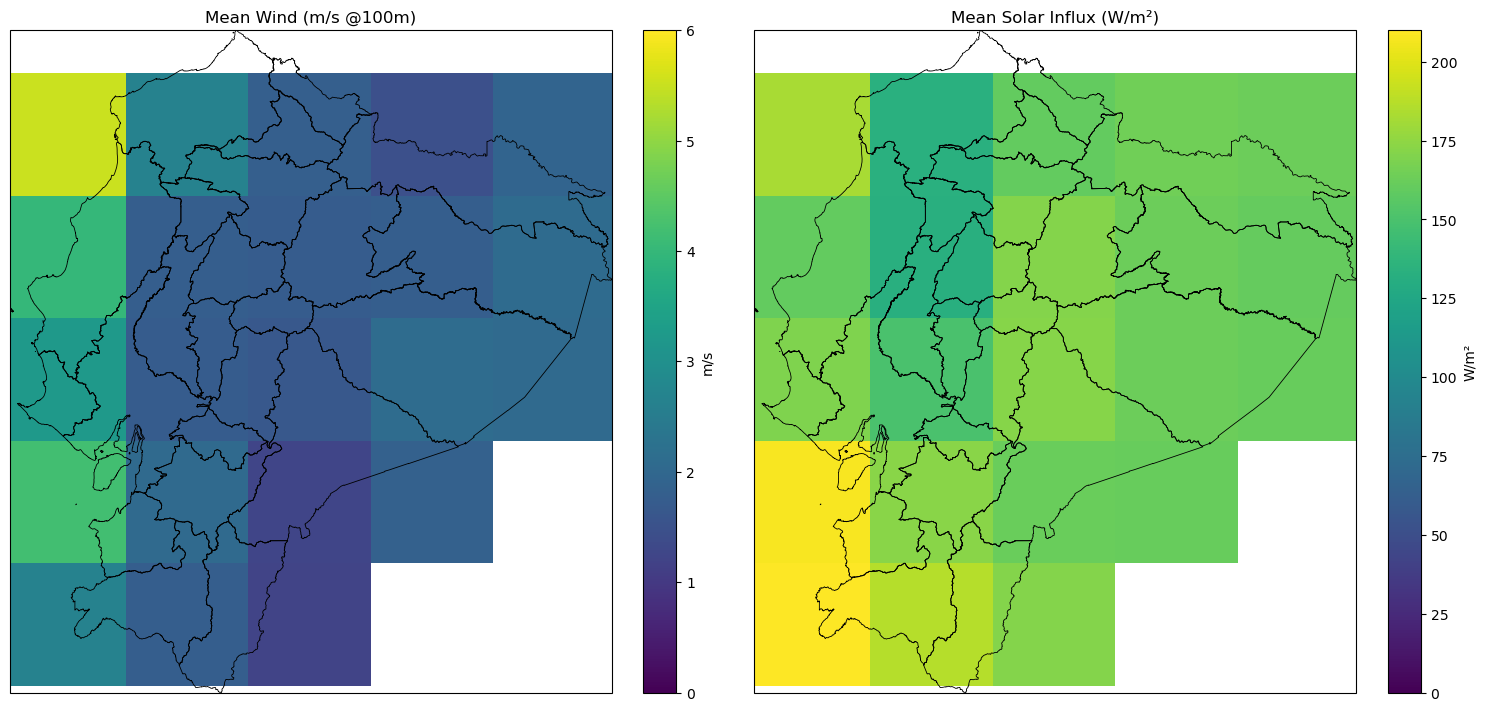

In [105]:
# ======================================================================
#                      9) Optional: quick wind/PV mean maps
# ======================================================================
def quick_wind_pv_maps(shapefile_gdf: gpd.GeoDataFrame, cutout_obj: atlite.Cutout):
    """Speed-optimized mainland-only mean maps for wind (m/s at 100m) and solar influx."""
    ds = cutout_obj.data[["wnd100m", "influx_direct", "influx_diffuse"]]
    X = "x" if "x" in ds.coords else ("lon" if "lon" in ds.coords else None)
    Y = "y" if "y" in ds.coords else ("lat" if "lat" in ds.coords else None)
    assert X and Y, f"Couldn't find spatial coords. Have: {list(ds.coords)}"

    shp_geo = shapefile_gdf.to_crs(4326)
    # Exclude Galapagos by centroid longitude (>-85 ~ mainland)
    continental = shp_geo[shp_geo.geometry.centroid.x > -85]
    minx, miny, maxx, maxy = continental.total_bounds

    # Crop quickly
    xslice = slice(minx, maxx) if ds[X][0] < ds[X][-1] else slice(maxx, minx)
    yslice = slice(miny, maxy) if ds[Y][0] < ds[Y][-1] else slice(maxy, miny)
    ds = ds.sel({X: xslice, Y: yslice})

    # Thin and coarsen for speed
    ds = ds.isel(time=slice(None, None, 6)).astype("float32").coarsen({X: 4, Y: 4}, boundary="trim").mean()

    wnd100m = ds["wnd100m"].mean(dim="time").compute()
    influx  = (ds["influx_direct"].mean(dim="time") + ds["influx_diffuse"].mean(dim="time")).compute()

    # Prepare grid edges
    def edges_from_centers(c):
        c = np.asarray(c, dtype=float)
        d = np.diff(c)
        e = np.empty(c.size + 1, dtype=float)
        e[1:-1] = c[:-1] + d/2
        e[0]     = c[0]  - d[0]/2
        e[-1]    = c[-1] + d[-1]/2
        return e

    x_cent = wnd100m[X].values
    y_cent = wnd100m[Y].values
    x_ed = edges_from_centers(x_cent)
    y_ed = edges_from_centers(y_cent)

    mainland_geom = unary_union(continental.geometry)

    # Mask by intersection
    mask = np.zeros((len(y_cent), len(x_cent)), dtype=bool)
    for j in range(len(y_cent)):
        for i in range(len(x_cent)):
            cell = box(x_ed[i], y_ed[j], x_ed[i+1], y_ed[j+1])
            mask[j, i] = cell.intersects(mainland_geom)

    wind_vals  = np.where(mask, wnd100m.values, np.nan)
    solar_vals = np.where(mask, influx.values,   np.nan)
    max_wind = np.nanmax(wind_vals)
    max_wind_ceil = int(np.ceil(max_wind))
    max_solar = np.nanmax(solar_vals)
    max_solar_ceil = int(np.ceil(max_solar / 10) * 10)
    fig, ax = plt.subplots(
        1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 7), constrained_layout=True
    )
    pc0 = ax[0].pcolormesh(x_ed, y_ed, wind_vals, transform=ccrs.PlateCarree(), vmin=0, 
                           vmax=max_wind_ceil
                           , shading='flat', rasterized=True)
    continental.plot(ax=ax[0], edgecolor="k", facecolor="none", linewidth=0.6)
    ax[0].set_title("Mean Wind (m/s @100m)")
    plt.colorbar(pc0, ax=ax[0], label="m/s")

    pc1 = ax[1].pcolormesh(x_ed, y_ed, solar_vals, transform=ccrs.PlateCarree(), vmin=0, 
                           vmax=max_solar_ceil, shading='flat', rasterized=True)
    continental.plot(ax=ax[1], edgecolor="k", facecolor="none", linewidth=0.6)
    ax[1].set_title("Mean Solar Influx (W/m²)")
    plt.colorbar(pc1, ax=ax[1], label="W/m²")

    for a in ax:
        a.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

    plt.show()

    return wind_vals, solar_vals

# Example usage (commented by default):
if shapefile is not None:
    wind_vals, solar_vals= quick_wind_pv_maps(shapefile, cutout)


In [106]:

# ======================================================================
#                      10) Final sanity log
# ======================================================================
logger.info(f"Network summary: buses={len(network.buses)}, lines={len(network.lines)}, generators={len(network.generators)}")


2025-11-10 12:58:51: Network summary: buses=296, lines=247, generators=64
